線形単回帰分析
==============

## データの確認

カリフォルニア住宅価格データを使って予測してみましょう。
このデータは、1990年のアメリカ合衆国の国勢調査に基づいて作成されたカリフォルニア州の住宅に関する情報を含んでいます。
データ数は約2万で、以下の8つの特徴量があります。

| 特徴量 | 説明 | 単位 |
|--------|------|------|
| MedInc | その地域の世帯収入の中央値 | なし（スケーリング済み） |
| HouseAge | その地域の住宅の平均年齢 | 年 |
| AveRooms | 平均部屋数 | 部屋数 |
| AveBedrms | 平均寝室数 | 部屋数 |
| Population | その地域の人口 | 人 |
| AveOccup | 平均世帯人数 | 人 |
| Latitude | 緯度 | 度 |
| Longitude | 経度 | 度 |

この8つの特徴量から住宅価格を予測します。
予測のために使われるデータを{index}`特徴量<とくちょうりょう - 特徴量>`、
予測するデータを{index}`目的変数<もくてきへんすう - 目的変数>`といいます。
ここでの目的変数は住宅価格になります。

pythonでデータを確認するプログラムを書いてみます。

In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['Price'] = dataset.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


このプログラムを実行すると、カリフォルニア住宅価格データセットの最初の5行が表示され、各特徴量と住宅価格（Price）を確認できます。

2行目は`scikit-learn`ライブラリからデータセットを取得する関数をインポートしています。
`scikit-learn`は、Pythonのための機械学習ライブラリです。
データ分析や統計モデリングのために広く使用されており、多様な機械学習アルゴリズムを提供しています。

5行目は`pandas`を使って、データセットの特徴量データをデータフレームに変換します。
`dataset.data`には特徴量の数値データが、`dataset.feature_names`には特徴量の名前が含まれています。
これにより、各列に適切な名前が付けられたデータフレームが作成されます。
6行目はデータフレームに新しい列`Price`を追加し、そこにデータセットの目的変数（住宅価格）を格納します。
`dataset.target`には住宅価格のデータが含まれています。

住宅価格と相関が高い特徴量を選ぶと予測が当てやすくなると思います。
住宅価格とそれぞれの特徴量との相関係数を計算し、ヒートマップとして視覚化するコードを書きます。

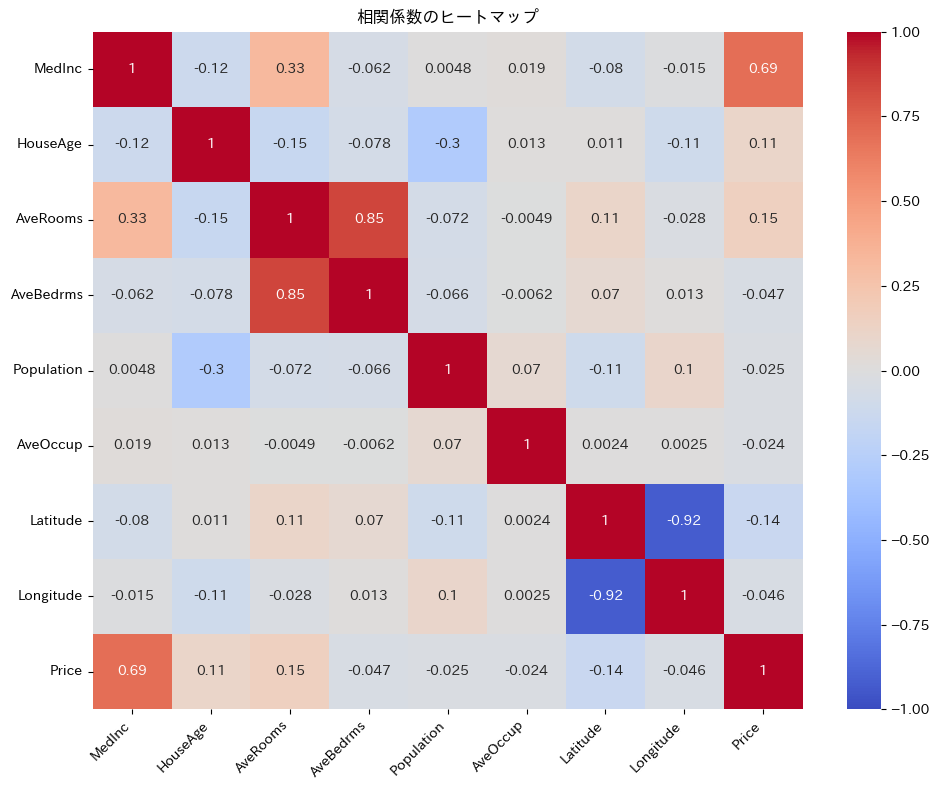

In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("相関係数のヒートマップ")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

対角線は自分との相関なのですべて1になります。
これは、ある変数が自身と完全に相関しているためです。

`df.corr()`は、データフレーム（df）内の数値列間の相関係数を計算します。

プログラムの結果から、MedIncが住宅価格と最も相関が高そうなので、
特徴量をMedInc、目的変数を住宅価格として考えます。

## データクリーニング

次に、MedIncと住宅価格がどのような関係になっているかを図で確認してみましょう。

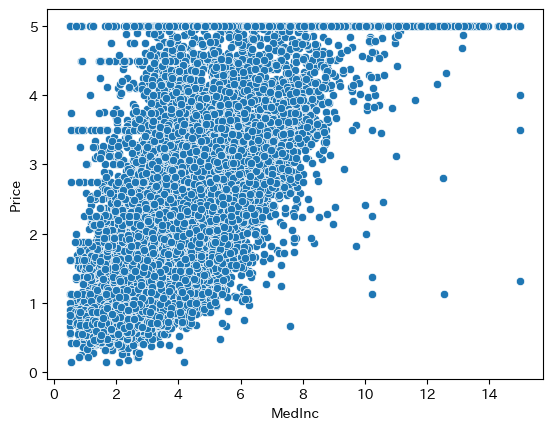

In [3]:
sns.scatterplot(x=df['MedInc'], y=df['Price'])
plt.show()

この図を見ると、Priceが5のところに一直線に並んでいたり、
MedIncが10以上のところでまばらに存在しています。
このようなデータは予測に悪影響を及ぼす可能性があります。

そのため、これらのデータポイントを適切に処理する必要があります。
外れ値を除去したり、変換したりすれば、より信頼性の高い分析が可能になります。

{ref}`subsec-normal`のところでも述べたように、平均から3標準偏差以上離れたデータを異常値や外れ値とする方法があり、
ここでは、その方法でデータの分布を改善してみましょう。

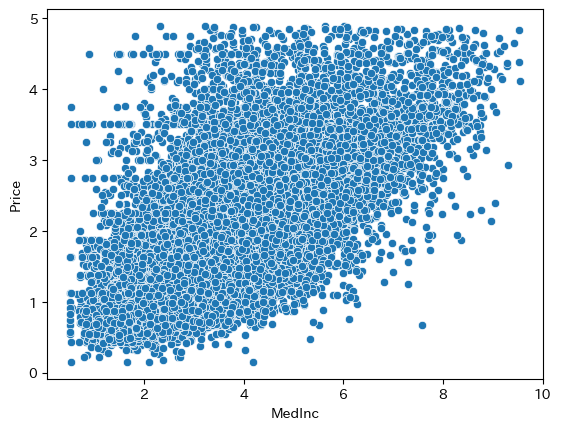

In [4]:
def remove_outliers_sigma(df, column, sigma=3):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - sigma * std
    upper_bound = mean + sigma * std
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = remove_outliers_sigma(df, 'MedInc')
df_cleaned = remove_outliers_sigma(df_cleaned, 'Price', 2.6)

sns.scatterplot(x=df_cleaned['MedInc'], y=df_cleaned['Price'])
plt.show()

前よりは改善されたのではないでしょうか。
住宅価格（Price）に関しては3シグマではなく、2.6シグマを採用しました。
この値は様々な試行を経て決定しました。
厳密な理論的根拠はありませんが、結果としておよそ99%のデータが保持されるようになっています。

## 最小二乗法

さて、このデータを使って予測をしてみましょう。
MedIncから住宅価格を予測するので、以下のような関数$f$を求めればよいでしょう。

```{math}
\text{住宅価格} = f(\text{MedInc})
```

これだけでは関数の具体的な形は分かりません。
この関数$f$の形を決定するために、{index}`回帰モデル<かいきもでる - 回帰モデル>`を使用します。

回帰モデルは、特徴量と目的変数の関係を数学的に表現する方法です。
最も単純で広く使用されている回帰モデルは{index}`線形回帰モデル<せんけいかいきもでる - 線形回帰モデル>`です。
線形回帰モデルでは、関数$f$を直線で近似します。

```{math}
f(\text{MedInc}) = a \cdot \text{MedInc} + b
```

では、このモデルの未知のパラメータ$a$と$b$をどのように決定すれば良いでしょうか。ここで最小二乗法を使います。

最小二乗法は、実際の観測値と予測値の差（残差）の二乗和を最小化するようなパラメータを見つける方法です。
具体的には、以下の式を最小化します。

```{math}
\sum_{i=1}^n (y_i - (b + a x_i))^2
```

ここで、$y_i$は実際の住宅価格、$x_i$はMedIncの値、$n$はデータポイントの総数です。

この最小化問題を解けば、データに最もフィットする直線、つまり最適な$a$と$b$を見つけられます。

では、この最小化問題を解くプログラムを書きましょう。

最適なパラメータ: a (傾き) = 0.4059, b (切片) = 0.4269


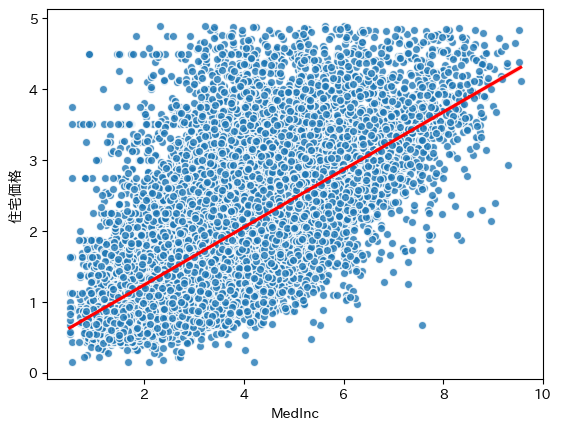

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = df_cleaned['MedInc'].values.reshape(-1, 1)
y = df_cleaned['Price'].values

model = LinearRegression()
model.fit(X, y)

print(f"最適なパラメータ: a (傾き) = {model.coef_[0]:.4f}, b (切片) = {model.intercept_:.4f}")

sns.regplot(x='MedInc', y='Price', data=df_cleaned, 
            scatter_kws={'edgecolor': 'white'},
            line_kws={'color': 'red'}
            )

plt.xlabel('MedInc')
plt.ylabel('住宅価格')
plt.show()

最小二乗法を使って傾きと切片を求めて直線を引いたものが図中の赤線になります。

プログラムの2行目は`scikit-learn`ライブラリの`linear_model`モジュールにある`LinearRegression`クラスをインポートしています。
`linear_model`は線形モデルに関連する様々な機能があり、その中でも最小二乗法による線形回帰をするクラスが`LinearRegression`です。

4、5行目では、dfのデータを`LinearRegression`が扱えるデータへ変換しています。
`df_cleaned['MedInc'].values`は、MedInc列からデータをNumPy配列として取り出します。
`.reshape(-1, 1)`は1次元の配列を2次元の配列に変換します。
`-1` は「この次元のサイズを自動的に決定する」という意味です。
`1` は「各行が1つの要素を持つ」という意味です。
結果として、$n$行1列の2次元配列が生成されます。ここで$n$はデータの数です。
この変換は、scikit-learnの多くの関数が特徴量として2次元配列、
目的変数として1次元配列の形式のデータ入力を必要とするためです。

7行目で線形回帰モデルを作り、8行目でそのモデルに対してfitメソッドを呼びます。
fitメソッドは、準備したデータ（XとY）を使ってモデルを調整します。
この過程を**学習**と呼びます。
学習とは、モデルがデータの特徴やパターンを理解し、それに基づいて最適な予測ができるようになることを指します。

10行目は学習後のモデルから、最適な直線の傾き（coefficient）と切片（intercept）を取得して表示しています。
12行目の`regplot`は、seabornライブラリの関数で、散布図と回帰直線を同時に描画します。

## 性能評価

先ほどのプログラムではすべてのデータを使って直線を求めていました。
しかし、これでは新しいデータを得るまで、そのモデルの精度（性能）を評価できません。
また、モデルの性能評価はどのようにすればよいのでしょうか。

この問題を解決し、モデルの性能を適切に評価するために、データを2つのグループに分けます。
最小二乗法を使用して最適なパラメータを求めるための**訓練データ**と
モデルを評価するための**テストデータ**です。
訓練に使用していないテストデータで予測を行い、その結果と実際の値を比較することで、モデルの性能を評価します。

ここではモデルの性能評価方法として2つ紹介します。
- {index}`平均二乗誤差<へいきんにじょうごさ - 平均二乗誤差>`（{index}`MSE: Mean Squared Error<Mean Squared Error - MSE>`）
- {index}`決定係数<けっていけいすう - 決定係数>`（{index}`R²: Coefficient of Determination<Coefficient of Determination - R²>`）

この方法は回帰問題での性能評価でよく使われます。

MSEは、予測値と実際の値の差（誤差）の二乗の平均です。
数式で表すと
```{math}
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
```
となります。
この値が0に近いほど良いモデルといえます。

決定係数は、モデルがデータの変動をどれだけ説明できるかを示す指標です。

数式で表すと
```{math}
R^2 = 1 - \frac{\displaystyle\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\displaystyle\sum_{i=1}^n (y_i - \bar{y})^2}
```
となります。
最大で1の値となり、1に近いほど良いモデルといえます。

ここで、$y_i$は実際の値、$\hat{y}_i$は予測値、$\bar{y}$は$y$の平均値、$n$ はデータ数です。

では、データを分割してモデルを評価するプログラムを書きます。

MSE: 0.52
R2: 0.42


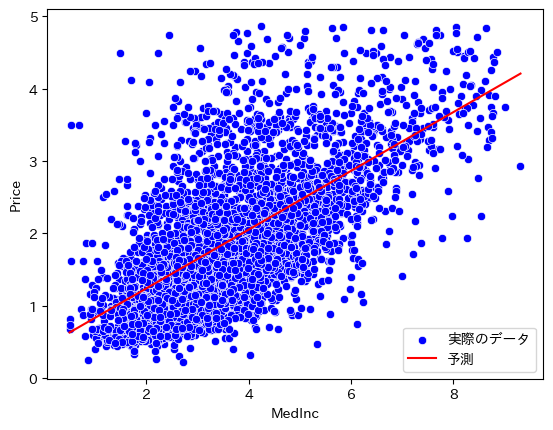

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2: {r2_score(y_test, y_pred):.2f}")

sns.scatterplot(x=X_test.squeeze(), y=y_test, color='blue', label='実際のデータ')
sns.lineplot(x=X_test.squeeze(), y=y_pred, color='red', label='予測')
plt.xlabel('MedInc')
plt.ylabel('Price')
plt.show()

4行目は`train_test_split`を使ってデータを2つに分割しています。
`test_size=0.2`は、全データの20%をテスト用、80%を訓練用に使うという意味です。

11行目は`mean_squared_error`を使って平均二乗誤差を計算、12行目は`r2_score`を使って決定係数を計算し、モデルの良さを確認しています。
決定係数は$R^2$あまり高くはないため、モデルに改善の余地があるといえます。

13行目からのプログラムでテストデータと予測結果をグラフ上に描画しています。
青い点は実際のテストデータを表し、赤い線は予測を表しています。
この予測線は、訓練データを使って学習した線形回帰モデルによるものです。

線形回帰の場合、予測結果は直線になります。
これは、線形回帰が入力変数と出力変数の間に線形の関係を仮定しているためです。
したがって、予測値はこの直線上に位置します。